In [4]:
# loading modules
import ee
import geemap
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# initialize ee 
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score


# import all FMSE py functions 
from FMSE import *


## Area of Interest

### a) Through filtering ADM2 boundaries

In [5]:
# testing 1 (shikarpur, jacabad, larkana)

# CASE 1: Pakistan Floods 2022

city = 'Shikarpur'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
    .filter(ee.Filter.inList('shapeName', ['Shikarpur']))#['Shikarpur', 'Jacobabad', 'Larkana']
    
# convert three features into one merged feature
city_shp = city_shp.union()


aoi = boundary(city_shp)

# Shikarpur

startDate = ee.Date('2022-02-01')
endDate = ee.Date('2022-09-01')
predays = 60
postdays = 7

#predays = 30
#postdays = 7

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 500
under_estimate = False

# print coordinates of aoi
#print(aoi.coordinates().getInfo())


In [2]:
# Case 2: Sylhet, Bangladesh Floods 2022

city = 'Sylhet'
city_shp = ee.FeatureCollection("projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2")\
    .filter(ee.Filter.eq('shapeName', city))


aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2022-01-01')
endDate = ee.Date('2022-05-17')
predays = 60
postdays = 10

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False

#print(aoi.coordinates().getInfo())

In [2]:
# Case 3: ernakulam

city = 'Ernakulam'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
    .filter(ee.Filter.eq('shapeName', city))


aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2018-01-01')
endDate = ee.Date('2018-08-07')
predays = 30
postdays = 20

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 500
under_estimate = False

In [2]:
# Case 4: Nhamatanda, Mozambique Floods 2019

city = 'Nhamatanda'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
                .filter(ee.Filter.eq('shapeName', city))



aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2019-01-01')
endDate = ee.Date('2019-03-19')
predays = 60
postdays = 1

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False


#print(aoi.coordinates().getInfo())


In [ ]:
# export Sofala shapefile
print(city)
geemap.ee_export_vector(city_shp, filename=f'shp/{city}.shp')
geemap.ee_export_vector(ee.FeatureCollection(aoi), filename=f'shp/{city}_box.shp')

## Flood layer Masking

In [6]:
# Fetching pre and post-flood images
s1_pre = get_s1_col(startDate, predays, aoi).select(['VV', 'VH'])
s1_post = get_s1_col(endDate, postdays, aoi).select(['VV', 'VH'])
print('Images in S1 Pre: ', s1_pre.size().getInfo())
print('Images in S1 Post: ', s1_post.size().getInfo())
# Calculate Z-score
z = calculate_zscore(s1_pre, s1_post, aoi)

# Generate flood masks
flood_class, flood_mask, ow = map_floods(z, aoi, zvv_value, zvh_value, water_value, elev_value, slope_value)

print('Done with flood masking...')

Images in S1 Pre:  20
Images in S1 Post:  2
Done with flood masking...


In [7]:
# Run flood mapping example
flood_classified= flood_mapping(aoi, s1_post, flood_mask, num_samples, split, city, export=False, accuracy=True)
print('Done with flood mapping...')

Done with preparing datasets...

 > Feature Importance: 
   Feature  Importance
1      VV      419.44
0      VH      418.58
2      b1      408.05
Done with classification...

 > Flood Mapping Accuracy Results: 
                    0
accuracy        0.86
precision       0.87
recall          0.83
f1_score        0.85
precision_mean  0.86
recall_mean     0.86
f1_mean         0.86
Done ...
Done with flood mapping...


In [5]:
# Run susceptibility analysis example
flood_susceptibility_prob = susceptibility_analysis(aoi, endDate, flood_mask, num_samples, split, city, export=True, accuracy=True)
sus_catagory = quantile_based_categorization(flood_susceptibility_prob, aoi)
flood_susceptibility_prob = flood_susceptibility_prob.clip(city_shp)
sus_catagory = sus_catagory.clip(city_shp)
flood_classified = flood_classified.where(ow, 3).clip(city_shp)

Done with preparing datasets for susceptibility analysis...
Bands for susceptibility analysis: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDWI', 'NDVI', 'NDBI', 'NDFI', 'WRI', 'elevation', 'slope', 'aspect', 'DtRiver']
Feature Importance:       Feature  Importance
14  elevation      174.51
0     DtRiver      128.88
15      slope      127.39
7       SR_B3      109.26
12        WRI      105.53
3        NDVI      104.94
6       SR_B2      104.42
5       SR_B1      101.46
13     aspect      101.35
8       SR_B4       98.88
2        NDFI       98.83
4        NDWI       98.00
11      SR_B7       97.26
1        NDBI       96.02
10      SR_B6       94.27
9       SR_B5       92.68

 > Flood Susceptibility Mapping Accuracy Results:                     0
accuracy        0.94
precision       0.95
recall          0.93
f1_score        0.94
precision_mean  0.94
recall_mean     0.94
f1_mean         0.94


### Visualize Data on the Map

In [ ]:
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(city_shp, {}, 'City Boundaries')
Map.addLayer(aoi, {}, 'AOI Boundary', False)
Map.addLayer(flood_class.clip(city_shp), {'min': 0, 'max': 4, 'palette': ['#FFFFFF','#FFA500','#FFFF00','#FF0000','#0000FF']}, 'Flood class', False)# non-flooded, vv, vh, vv+vh, water
# using ow layer to change pixels in flood_classified to 3
Map.addLayer(flood_classified, {'min': 1, 'max': 3, 'palette': ['#00FFFF', '#f3f7f7', '#0000FF']}, 'Flood layer (with OW)')
Map.addLayer(flood_susceptibility_prob, {'min': 0.1, 'max': 0.9, 'palette': ['#1a9641', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility', False)
#Map.addLayer(sus_catagory, {'min': 1, 'max': 5, 'palette': ['#1a9641', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility Categorical')
Map

### Model Tuning Optional

In [10]:
import time





def update_feature(feature):
    value = feature.get('label')
    updated_value = ee.Algorithms.If(ee.Algorithms.IsEqual(value, ee.Number(2)), ee.Number(0), value)
    return feature.set('label', updated_value)
bands = ['VV', 'VH', 'elevation']#, 'slope', 'aspect', 'dtriver']

def prepare_datasets(aoi, projection='EPSG:4326', scale=30):
    """
    Prepare DEM, slope, and aspect datasets.

    Parameters:
    aoi (ee.Geometry): Area of Interest.
    projection (str): Projection to reproject the images. Default is 'EPSG:4326'.
    scale (int): Scale for reprojection. Default is 30.

    Returns:
    tuple: DEM, slope, aspect, and dtriver images reprojected to the specified projection.
    """
    dem_proj = ee.ImageCollection("projects/sat-io/open-datasets/FABDEM")\
        .filterBounds(aoi)\
        .mosaic()\
        .clip(aoi)\
        .setDefaultProjection('EPSG:3857', None, 30)

    slope_proj = ee.Terrain.slope(dem_proj)
    aspect_proj = ee.Terrain.aspect(dem_proj)

    dem = dem_proj.reproject(crs=projection, scale=scale)
    slope = slope_proj.reproject(crs=projection, scale=scale)
    aspect = aspect_proj.reproject(crs=projection, scale=scale)
    
    shoreline = ee.FeatureCollection('projects/sat-io/open-datasets/shoreline/mainlands')\
        .merge(ee.FeatureCollection('projects/sat-io/open-datasets/shoreline/big_islands'))\
        .filterBounds(aoi)
    
    rivers = ee.FeatureCollection("projects/sat-io/open-datasets/HydroAtlas/RiverAtlas_v10")\
        .filterBounds(aoi)

    # Combine rivers and shoreline into a single FeatureCollection
    rivers_and_shoreline = rivers.merge(shoreline)

    # Generate distance rasters for roads, and rivers+shoreline
    dtriver = distance_to_feature(rivers_and_shoreline, projection, scale, aoi)
    #rivers_and_shoreline_distance = distance_to_feature(rivers_and_shoreline, 30)

    return dem.rename('elevation'), slope, aspect, dtriver.rename('DistRiver')


def prepare_samples(flood_layer, num_samples, aoi, scale=30, split=0.8):
    sample = flood_layer.stratifiedSample(
        numPoints=num_samples,
        classBand='label',
        region=aoi,
        scale=scale,
        seed=5,
        tileScale=1.5,
        geometries=True
    )
    label = sample.map(update_feature)

    image = s1_post.mean().clip(aoi).toFloat()
    
    dem, slope, aspect, dtriver = prepare_datasets(aoi, scale=30)
    
    image = image.addBands(dem)#.addBands(slope).addBands(aspect).addBands(dtriver)
    sample_all = image.sampleRegions(
        collection=label,
        properties=['label'],
        scale=scale
    ).randomColumn()

    training = sample_all.filter(ee.Filter.lt('random', split))
    validation = sample_all.filter(ee.Filter.gte('random', split))
    return image, training, validation

def evaluate_classifier(classifier, training, validation):
    start_time = time.time()
    
    trained_classifier = classifier.train(
        features=training,
        classProperty='label',
        inputProperties=bands
    )
    
    training_classified = training.classify(trained_classifier)
    validation_classified = validation.classify(trained_classifier)
    
    training_accuracy = training_classified.errorMatrix('label', 'classification')
    validation_accuracy = validation_classified.errorMatrix('label', 'classification')
    
    end_time = time.time()
    prediction_time = end_time - start_time
    
    return {
        'train_f1': training_accuracy.fscore().getInfo()[1] if len(training_accuracy.fscore().getInfo()) > 1 else None,
        'validation_f1': validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None,
        'train_producer_accuracy': training_accuracy.producersAccuracy().getInfo()[1] if len(training_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'validation_producer_accuracy': validation_accuracy.producersAccuracy().getInfo()[1] if len(validation_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'train_consumer_accuracy': training_accuracy.consumersAccuracy().getInfo()[1] if len(training_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'validation_consumer_accuracy': validation_accuracy.consumersAccuracy().getInfo()[1] if len(validation_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'prediction_time': prediction_time
    }

def compare_models(flood_layer, s1_post, aoi, num_samples=1000, split=0.8):
    
    image, training, validation = prepare_samples(flood_layer, num_samples, aoi, scale=30, split=split)
    bands = image.bandNames().getInfo()
    print(bands)
    classifiers = {
        'RandomForest': ee.Classifier.smileRandomForest(100),
        'GradientTreeBoost': ee.Classifier.smileGradientTreeBoost(50),
        'DecisionTree': ee.Classifier.smileCart(),
        'SVM': ee.Classifier.libsvm()
    }

    results = {}
    for name, classifier in classifiers.items():
        print(f"Evaluating {name} classifier...")
        results[name] = evaluate_classifier(classifier, training, validation)
    
    for name, metrics in results.items():
        print(f"\nClassifier: {name}")
        print(f"Training F1 Score: {metrics['train_f1']}")
        print(f"Validation F1 Score: {metrics['validation_f1']}")
        print(f"Training Producer Accuracy: {metrics['train_producer_accuracy'][0]}")
        print(f"Validation Producer Accuracy: {metrics['validation_producer_accuracy'][0]}")
        print(f"Training Consumer Accuracy: {metrics['train_consumer_accuracy']}")
        print(f"Validation Consumer Accuracy: {metrics['validation_consumer_accuracy']}")
        print(f"Prediction Time: {metrics['prediction_time']} seconds")

    return results

# Example usage

results = compare_models(flood_layer=flood_mask.rename('label'), s1_post=s1_post, aoi=aoi, num_samples=1000, split=0.8)

# results to df

models_compare_df = pd.DataFrame(results).T
models_compare_df.reset_index(inplace=True)
models_compare_df.rename(columns={'index': 'Model'}, inplace=True)
models_compare_df = models_compare_df.round(2)
models_compare_df.to_csv(f'{city}_all_models_compare_df.csv', index=False)
models_compare_df


['VV', 'VH', 'elevation']
Evaluating RandomForest classifier...
Evaluating GradientTreeBoost classifier...
Evaluating DecisionTree classifier...
Evaluating SVM classifier...

Classifier: RandomForest
Training F1 Score: 0.994343180389692
Validation F1 Score: 0.9643705463182898
Training Producer Accuracy: 1
Validation Producer Accuracy: 0.9712918660287081
Training Consumer Accuracy: None
Validation Consumer Accuracy: None
Prediction Time: 0.0 seconds

Classifier: GradientTreeBoost
Training F1 Score: 0.9691358024691357
Validation F1 Score: 0.9620853080568721
Training Producer Accuracy: 0.9924146649810367
Validation Producer Accuracy: 0.9712918660287081
Training Consumer Accuracy: None
Validation Consumer Accuracy: None
Prediction Time: 0.0 seconds

Classifier: DecisionTree
Training F1 Score: 1
Validation F1 Score: 0.9353233830845771
Training Producer Accuracy: 1
Validation Producer Accuracy: 0.8995215311004785
Training Consumer Accuracy: None
Validation Consumer Accuracy: None
Prediction 

,Model,train_f1,validation_f1,train_producer_accuracy,validation_producer_accuracy,train_consumer_accuracy,validation_consumer_accuracy,prediction_time
0,RandomForest,0.994343,0.964371,[1],[0.9712918660287081],None,None,0.0
1,GradientTreeBoost,0.969136,0.962085,[0.9924146649810367],[0.9712918660287081],None,None,0.0
2,DecisionTree,1,0.935323,[1],[0.8995215311004785],None,None,0.0
3,SVM,0.962825,0.964371,[0.9823008849557522],[0.9712918660287081],None,None,0.0


Evaluated RandomForest with 10 trees: F1 Score = 0.9567307692307692
Evaluated RandomForest with 20 trees: F1 Score = 0.964200477326969
Evaluated RandomForest with 30 trees: F1 Score = 0.9665071770334929
Evaluated RandomForest with 40 trees: F1 Score = 0.9619047619047619
Evaluated RandomForest with 50 trees: F1 Score = 0.9619047619047619
Evaluated RandomForest with 60 trees: F1 Score = 0.9619047619047619
Evaluated RandomForest with 70 trees: F1 Score = 0.9619047619047619
Evaluated RandomForest with 80 trees: F1 Score = 0.9619047619047619
Evaluated RandomForest with 90 trees: F1 Score = 0.9643705463182898
Evaluated RandomForest with 100 trees: F1 Score = 0.9643705463182898
Evaluated RandomForest with 110 trees: F1 Score = 0.9666666666666666
Evaluated RandomForest with 120 trees: F1 Score = 0.9666666666666666
Evaluated RandomForest with 130 trees: F1 Score = 0.9666666666666666
Evaluated RandomForest with 140 trees: F1 Score = 0.9643705463182898
Evaluated RandomForest with 150 trees: F1 Sc

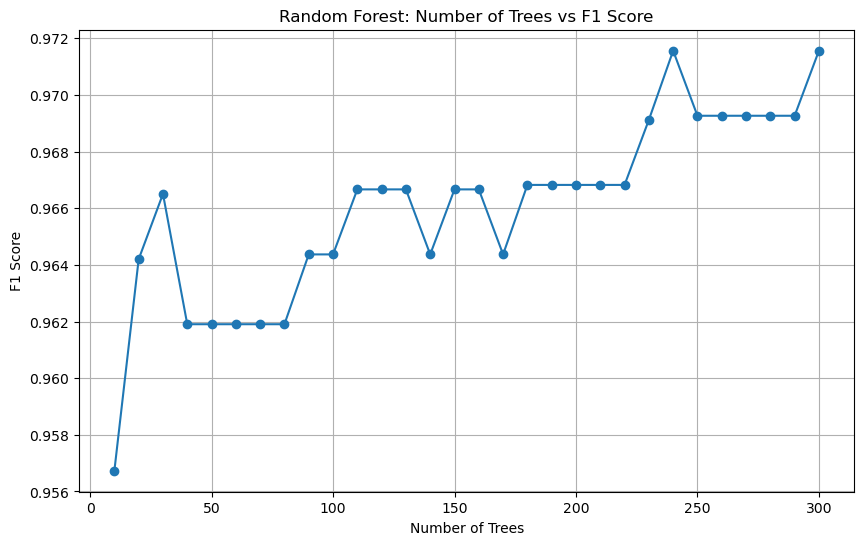

,Number of Trees,F1 Score
0,10,0.956731
1,20,0.964200
2,30,0.966507
3,40,0.961905
4,50,0.961905
5,60,0.961905
6,70,0.961905
7,80,0.961905
8,90,0.964371
9,100,0.964371


In [11]:
import matplotlib.pyplot as plt

def update_feature(feature):
    value = feature.get('label')
    updated_value = ee.Algorithms.If(ee.Algorithms.IsEqual(value, ee.Number(2)), ee.Number(0), value)
    return feature.set('label', updated_value)
bands = ['VV', 'VH', 'elevation']#, 'slope', 'aspect', 'dtriver']

def prepare_datasets(aoi, projection='EPSG:4326', scale=30):
    """
    Prepare DEM, slope, and aspect datasets.

    Parameters:
    aoi (ee.Geometry): Area of Interest.
    projection (str): Projection to reproject the images. Default is 'EPSG:4326'.
    scale (int): Scale for reprojection. Default is 30.

    Returns:
    tuple: DEM, slope, aspect, and dtriver images reprojected to the specified projection.
    """
    dem_proj = ee.ImageCollection("projects/sat-io/open-datasets/FABDEM")\
        .filterBounds(aoi)\
        .mosaic()\
        .clip(aoi)\
        .setDefaultProjection('EPSG:3857', None, 30)

    slope_proj = ee.Terrain.slope(dem_proj)
    aspect_proj = ee.Terrain.aspect(dem_proj)

    dem = dem_proj.reproject(crs=projection, scale=scale)
    slope = slope_proj.reproject(crs=projection, scale=scale)
    aspect = aspect_proj.reproject(crs=projection, scale=scale)
    
    shoreline = ee.FeatureCollection('projects/sat-io/open-datasets/shoreline/mainlands')\
        .merge(ee.FeatureCollection('projects/sat-io/open-datasets/shoreline/big_islands'))\
        .filterBounds(aoi)
    
    rivers = ee.FeatureCollection("projects/sat-io/open-datasets/HydroAtlas/RiverAtlas_v10")\
        .filterBounds(aoi)

    # Combine rivers and shoreline into a single FeatureCollection
    rivers_and_shoreline = rivers.merge(shoreline)

    # Generate distance rasters for roads, and rivers+shoreline
    dtriver = distance_to_feature(rivers_and_shoreline, projection, scale, aoi)
    #rivers_and_shoreline_distance = distance_to_feature(rivers_and_shoreline, 30)

    return dem.rename('elevation'), slope, aspect, dtriver.rename('DistRiver')


def prepare_samples(flood_layer, num_samples, aoi, scale=30, split=0.8):
    sample = flood_layer.stratifiedSample(
        numPoints=num_samples,
        classBand='label',
        region=aoi,
        scale=scale,
        seed=5,
        tileScale=1.5,
        geometries=True
    )
    label = sample.map(update_feature)

    image = s1_post.mean().clip(aoi).toFloat()
    
    dem, slope, aspect, dtriver = prepare_datasets(aoi, scale=30)
    
    image = image.addBands(dem)#.addBands(slope).addBands(aspect).addBands(dtriver)
    sample_all = image.sampleRegions(
        collection=label,
        properties=['label'],
        scale=scale
    ).randomColumn()

    training = sample_all.filter(ee.Filter.lt('random', split))
    validation = sample_all.filter(ee.Filter.gte('random', split))
    return image, training, validation


def evaluate_rf_trees(training, validation, bands, num_trees_list):
    results = {}
    
    for num_trees in num_trees_list:
        classifier = ee.Classifier.smileRandomForest(num_trees).train(
            features=training,
            classProperty='label',
            inputProperties=bands
        )
        
        validation_classified = validation.classify(classifier)
        validation_accuracy = validation_classified.errorMatrix('label', 'classification')
        f1_score = validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None
        
        results[num_trees] = f1_score
        print(f"Evaluated RandomForest with {num_trees} trees: F1 Score = {f1_score}")
    
    return results


new_trees = list(range(10, 310, 10))# 10 to 300 trees in steps of 10
def fine_tune_rf_trees(flood_layer, s1_post, aoi, num_samples=200, split=0.8, num_trees_list=new_trees):
    if num_trees_list is None:
        num_trees_list = [10, 50, 100, 150, 200, 250, 300]

    
    image, training, validation = prepare_samples(flood_layer, num_samples, aoi, scale=30, split=split)
    bands = image.bandNames().getInfo()
    results = evaluate_rf_trees(training, validation, bands, num_trees_list)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel('Number of Trees')
    plt.ylabel('F1 Score')
    plt.title('Random Forest: Number of Trees vs F1 Score')
    plt.grid(True)
    plt.savefig(f'{city}_rf_trees_f1_score.png', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)
    plt.show()
    
    return results

# Example usage
results_rf_trees = fine_tune_rf_trees(flood_mask.rename('label'), s1_post, aoi, num_samples=1000, split=0.8)
# save df results_rf_trees to csv
results_rf_trees_df = pd.DataFrame(results_rf_trees, index=[0]).T
results_rf_trees_df.reset_index(inplace=True)
results_rf_trees_df.rename(columns={'index': 'Number of Trees', 0: 'F1 Score'}, inplace=True)
results_rf_trees_df.to_csv(f'{city}_rf_trees_f1_score_df.csv', index=False)
results_rf_trees_df


# Exposure Analysis

## A) Exposure to Flood Hazard

### Population Exposed to Floods

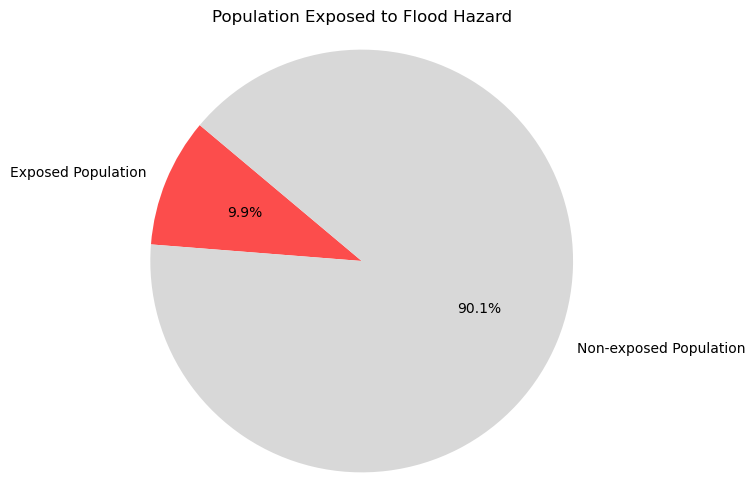

Total population: 310217
Population exposed to flood hazard: 30591


In [15]:
total_exposed_population, total_population = calculate_flood_exposure(flood_binary, city_shp.geometry())

# print total population without decimal points
print('Total population:', int(total_population.getInfo()))
print('Population exposed to flood hazard:', int(total_exposed_population.getInfo()))


### Population Exposed to flood hazard OR Susceptibility Levels

In [3]:
# Calculate exposure dataframe

# unccomment below for exposure due to flood hazard calculation
#exposure_df = calculate_exposure_df(flood_binary, aoi, flood_map=True)

# import all FMSE py functions 
# asset layers
print(city)
Shikarpur_flood_category_path = 'projects/waleedgeo/assets/Shikarpur_flood_susceptibility_category_layer'
Sylhet_flood_category_path = 'projects/waleedgeo/assets/Sylhet_flood_susceptibility_category_layer'
Ernakulam_flood_category_path = 'projects/temporaryproj/assets/Ernakulam_flood_susceptibility_category_layer'
nhamatanda_flood_category_path = 'projects/waleedgeo/assets/Nhamatanda_flood_susceptibility_category_layer'


sus_catagory = ee.Image(Ernakulam_flood_category_path)
#sus_catagory = ee.Image(Ernakulam_flood_category_path)
exposure_df = calculate_exposure_df(sus_catagory, city_shp.geometry(), crs='EPSG:3395', flood_map=False, export=True, city=city)

# Print the updated dataframe
print(exposure_df)


Nhamatanda
   Susceptibility Level   Category  Exposed Population  \
0                     1   Very Low               46398   
1                     2        Low               79540   
2                     3   Moderate               68745   
3                     4       High               68892   
4                     5  Very High               46584   

   Exposed Nighttime Light  lulc_water  lulc_trees  lulc_flooded_vegetation  \
0                     0.00        1.88    26352.90                     0.00   
1                    24.58       16.48    43251.89                     5.64   
2                    52.83       67.51    25176.97                    60.13   
3                   109.10      569.25    17186.78                   287.02   
4                    16.35     2123.91     7166.43                  4235.19   

   lulc_crops  lulc_built_area  lulc_bare_ground  ...  ntl_p  lulc_water_p  \
0      131.40           224.45              0.94  ...   0.00          0.07   
1      94

In [ ]:

def export_layers_to_drive(aoi, city):
    """
    Export population, nighttimelight, and lulc layers to Google Drive.

    Parameters:
    aoi (ee.Geometry): Area of Interest.
    city (str): Name of the city for the export description.
    """
    # Load datasets
    population = ee.ImageCollection('WorldPop/GP/100m/pop')\
                    .filter(ee.Filter.eq('year', 2020))\
                    .mosaic()\
                    .rename('population')
    nightlight = ee.Image('projects/sat-io/open-datasets/npp-viirs-ntl/LongNTL_2022').rename('ntl')
    landcover = ee.ImageCollection('projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS')\
                    .filterDate('2022-01-01', '2022-12-31')\
                    .mosaic().rename('lulc')

    # Clip the datasets to the AOI
    population_clipped = population.clip(aoi)
    nightlight_clipped = nightlight.clip(aoi)
    landcover_clipped = landcover.clip(aoi)

    # Export population layer to Google Drive
    population_task = ee.batch.Export.image.toDrive(
        image=population_clipped,
        description=f'{city}_population',
        folder='FMSE',
        scale=100,
        region=aoi.geometry(),
        maxPixels=1e13
    )
    population_task.start()

    # Export nighttimelight layer to Google Drive
    nightlight_task = ee.batch.Export.image.toDrive(
        image=nightlight_clipped,
        description=f'{city}_nighttimelight',
        folder='FMSE',
        scale=100,
        region=aoi.geometry(),
        maxPixels=1e13
    )
    nightlight_task.start()

    # Export lulc layer to Google Drive
    landcover_task = ee.batch.Export.image.toDrive(
        image=landcover_clipped,
        description=f'{city}_landcover',
        folder='FMSE',
        scale=10,
        region=aoi.geometry(),
        maxPixels=1e13
    )
    landcover_task.start()

    # Monitor the export tasks
    def monitor_tasks(tasks):
        while any([task.status()['state'] in ['READY', 'RUNNING'] for task in tasks]):
            for task in tasks:
                status = task.status()
                description = status['description']
                state = status['state']
                print(f'Task {description} is {state}')
            time.sleep(30)  # Check every 30 seconds

    # Monitor the export tasks
    monitor_tasks([population_task, nightlight_task, landcover_task])


export_layers_to_drive(city_shp, city)


In [ ]:
visualize_exposure(exposure_df, export=False)


## Export Layers

In [9]:
# export variables

def export_bands(image, bands, region, scale=30):
    tasks = []
    
    for band in bands:
        export_task = ee.batch.Export.image.toDrive(
            
            image=image.select(band),
            description=f'{city}_{band}',
            folder='FMSE',
            scale=30,
            region=region,
            maxPixels=1e13
        )
        export_task.start()
        tasks.append(export_task)
        
    return tasks



# Prepare the Landsat image
landsat_filtered = prepare_landsat_images(city_shp.geometry(), endDate)

# Prepare datasets for susceptibility analysis
image_sus = prepare_datasets_for_susceptibility(city_shp.geometry(), landsat_filtered)

# List of bands to export
bands_to_export = image_sus.bandNames().getInfo()
print(bands_to_export)
# Export bands to Google Drive
export_bands(image_sus, bands_to_export, city_shp.geometry(), scale=30)


Done with preparing datasets for susceptibility analysis...
['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDWI', 'NDVI', 'NDBI', 'NDFI', 'WRI', 'elevation', 'slope', 'aspect', 'DtRiver']


[<Task KH3DIAATISSJVHC6HYSJLCYY Type.EXPORT_IMAGE: Nhamatanda_SR_B1 (State.UNSUBMITTED)>,
 <Task UEUWW3YQQPY4EH7RMVTSVKYX Type.EXPORT_IMAGE: Nhamatanda_SR_B2 (State.UNSUBMITTED)>,
 <Task 6B5KDMF5LGYRPK7KMHSQNN3U Type.EXPORT_IMAGE: Nhamatanda_SR_B3 (State.UNSUBMITTED)>,
 <Task FCP6B632SQF2TWEWSZAYPEE3 Type.EXPORT_IMAGE: Nhamatanda_SR_B4 (State.UNSUBMITTED)>,
 <Task GU5ATMDW6SK76BT4JAJMVXEA Type.EXPORT_IMAGE: Nhamatanda_SR_B5 (State.UNSUBMITTED)>,
 <Task LMWBB6SHDGTGLTY2TWIEAOEO Type.EXPORT_IMAGE: Nhamatanda_SR_B6 (State.UNSUBMITTED)>,
 <Task 6PFBTK632DSRS7BDY62R52JG Type.EXPORT_IMAGE: Nhamatanda_SR_B7 (State.UNSUBMITTED)>,
 <Task QS6R3U3TI2TNIR5JFSNL375A Type.EXPORT_IMAGE: Nhamatanda_NDWI (State.UNSUBMITTED)>,
 <Task YLBHSBA3AKLKQG4TGBNGDGIR Type.EXPORT_IMAGE: Nhamatanda_NDVI (State.UNSUBMITTED)>,
 <Task EY7TBZZNCFKX5JKZNZJ7U26M Type.EXPORT_IMAGE: Nhamatanda_NDBI (State.UNSUBMITTED)>,
 <Task NMBMFD7YQXSXJKC3N3SDPBRV Type.EXPORT_IMAGE: Nhamatanda_NDFI (State.UNSUBMITTED)>,
 <Task KBIT5LG

In [7]:
#def export_image_to_asset(image, description, asset_id, region, scale):
#    """
#    Export an ee.Image to an Earth Engine asset and monitor the upload progress.

export_image_to_asset(sus_catagory, f'{city}_flood_susceptibility_category', f'projects/waleedgeo/assets/{city}_flood_susceptibility_category_layer', city_shp.geometry(), 30)



Task status: {'state': 'READY', 'description': 'Nhamatanda_flood_susceptibility_category', 'creation_timestamp_ms': 1720071727862, 'update_timestamp_ms': 1720071727862, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'ZC2J6L5SKNZOAXXWB6NTPC44', 'name': 'projects/earthengine-legacy/operations/ZC2J6L5SKNZOAXXWB6NTPC44'}
Task status: {'state': 'RUNNING', 'description': 'Nhamatanda_flood_susceptibility_category', 'creation_timestamp_ms': 1720071727862, 'update_timestamp_ms': 1720071734003, 'start_timestamp_ms': 1720071733922, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'ZC2J6L5SKNZOAXXWB6NTPC44', 'name': 'projects/earthengine-legacy/operations/ZC2J6L5SKNZOAXXWB6NTPC44'}
Task status: {'state': 'RUNNING', 'description': 'Nhamatanda_flood_susceptibility_category', 'creation_timestamp_ms': 1720071727862, 'update_timestamp_ms': 1720071734003, 'start_timestamp_ms': 1720071733922, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'ZC2J6L5SKNZOAXXWB6NTPC44', 'name': 'projects/earth

KeyboardInterrupt: 

In [8]:
# # export to gdrive
#def export_layers(aoi, city, flood_layer, flood_class, flood_mapped, susceptibility_layer, susceptibility_category_layer,
#                  export_flood_layer=True, export_flood_class=True, export_flood_mapped=True,
#                  export_susceptibility_layer=True, export_susceptibility_category_layer=True):
#    """


export_layers(city_shp,
              city,
              flood_mask, flood_class, flood_classified, flood_susceptibility_prob, sus_catagory,
               export_flood_layer=True, 
               export_flood_class=True, 
               export_flood_mapped=True,
               export_susceptibility_layer=True, 
               export_susceptibility_category_layer=True)


Task Nhamatanda_flood_mask_layer is RUNNING
Task Nhamatanda_flood_class_layer is RUNNING
Task Nhamatanda_flood_mapped_layer is RUNNING
Task Nhamatanda_flood_susceptibility_layer is READY
Task Nhamatanda_flood_susceptibility_category_layer is READY
Task Nhamatanda_flood_mask_layer is RUNNING
Task Nhamatanda_flood_class_layer is RUNNING
Task Nhamatanda_flood_mapped_layer is RUNNING
Task Nhamatanda_flood_susceptibility_layer is READY
Task Nhamatanda_flood_susceptibility_category_layer is READY


KeyboardInterrupt: 